In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from environment.models.simple_control_fixed import SimpleControlledFixedEnv

env = SimpleControlledFixedEnv()

2024-05-06 12:05:49.719392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 12:05:49.880980: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
env.max_t = 1
env.reset()

while not env.done:
    env.step()

QBER = env.get_qber()

In [3]:
QBER = np.load('data/QBER.npy')

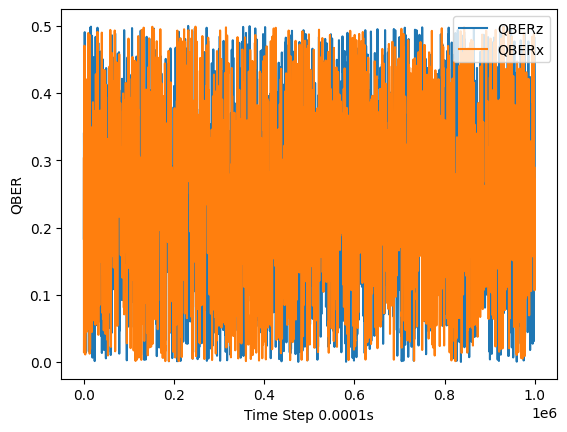

In [4]:
plt.plot(QBER[:,0],label='QBERz')
plt.plot(QBER[:,1],label='QBERx')
plt.legend(loc = 'upper right')
plt.ylabel('QBER')
plt.xlabel(f'Time Step {env.delta_t}s')
plt.show()

In [5]:
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

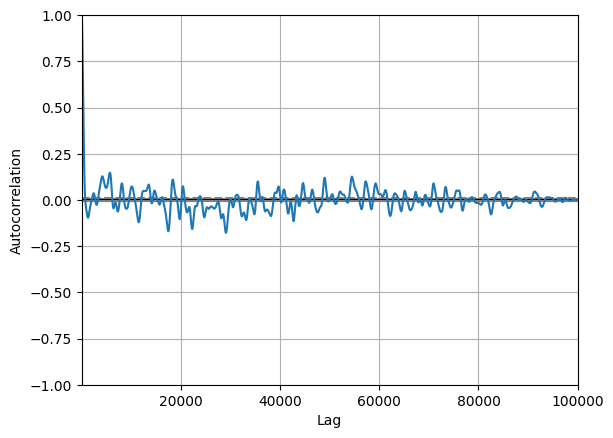

In [6]:
autocorrelation_plot(QBER[:100000,0])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

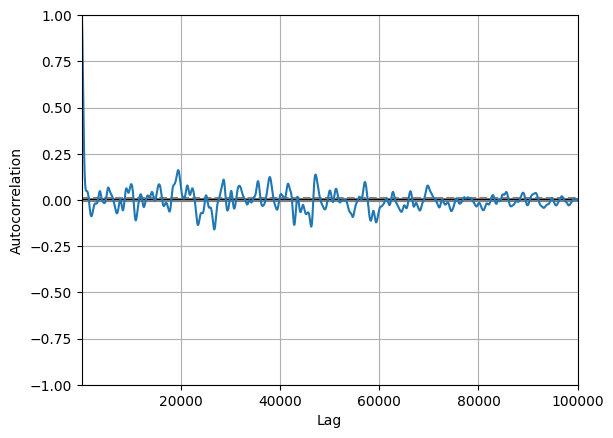

In [7]:
autocorrelation_plot(QBER[:100000,1])

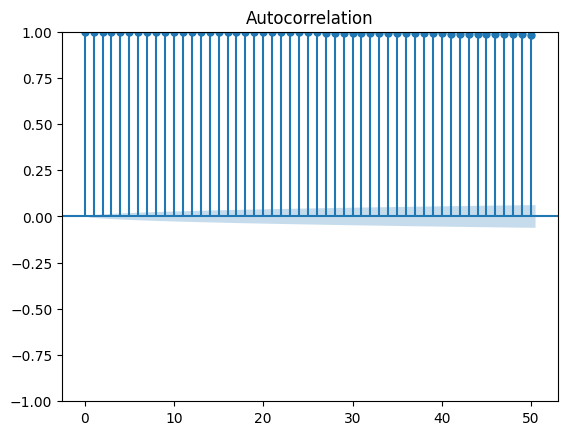

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(QBER[:100000,0])
plt.show()

In [9]:
qberz = QBER[:100000,0]

In [10]:
# import pmdarima as pmd

# model=pmd.auto_arima(QBER[:100000,0],start_p=1,start_q=1,test='adf',seasonal=True,trace=True)

In [11]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(qberz, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)
# p-value <= significance level (0.01, 0.05, 0.10, etc.)
# If the p-value is greater than the significance level then
# we can say that it is likely that the data is not stationary.

Results of Dickey Fuller Test:
Test Statistic                    -0.690954
p-value                            0.849079
#Lags Used                         4.000000
Number of Observations Used    99995.000000
Critical Value (1%)               -3.430415
Critical Value (5%)               -2.861569
Critical Value (10%)              -2.566785
dtype: float64


p-value > 0.05 => Data is not stationary

In [12]:
import pmdarima as pmd

#Standard ARIMA Model
ARIMA_model = pmd.auto_arima(qberz, 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_auto_solvers.py:5

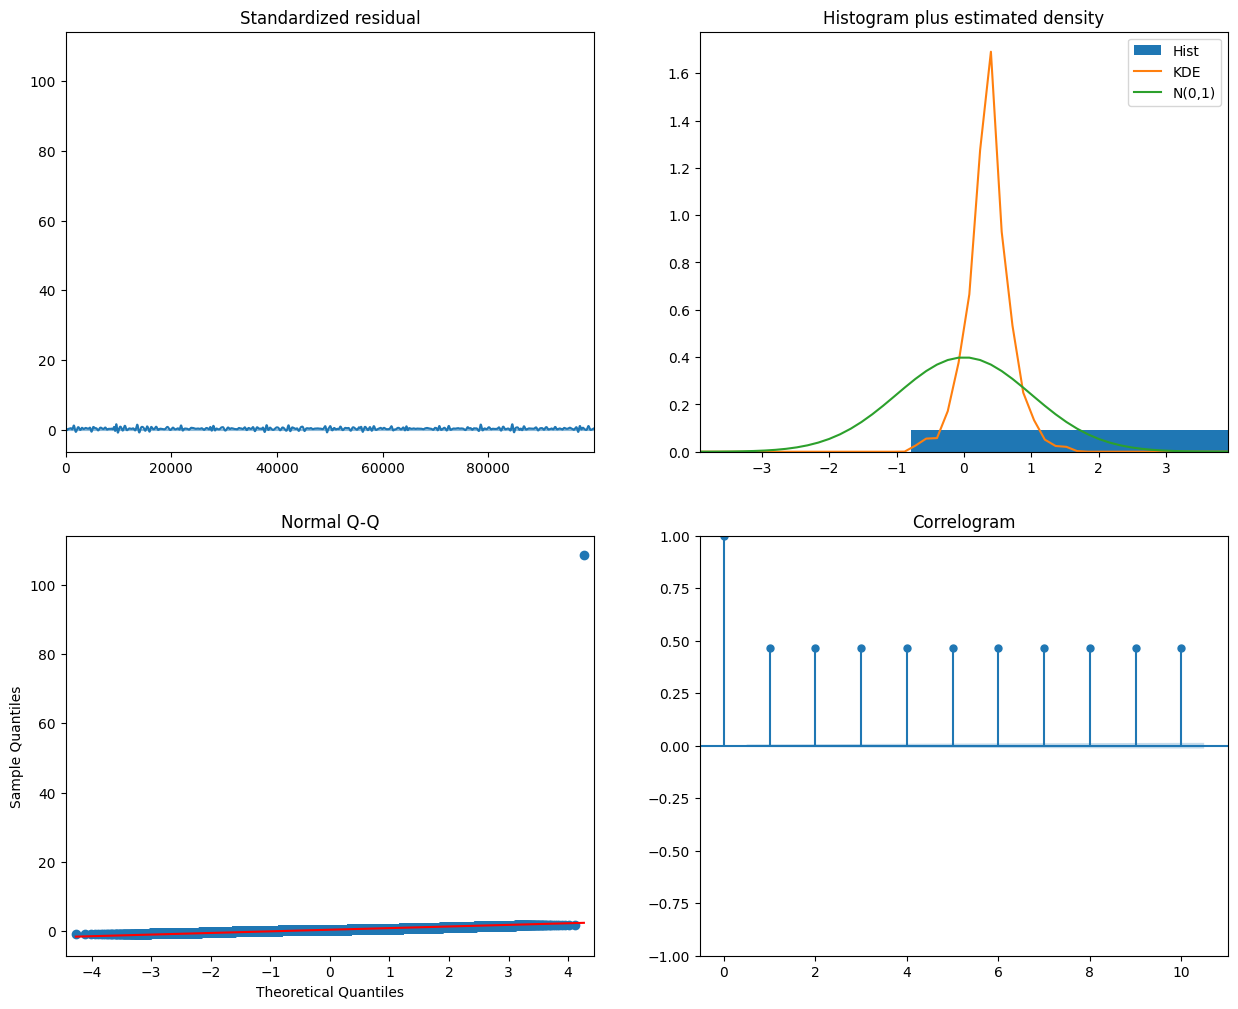

In [13]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

### Standardized residual

There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

### Histogram plus KDE estimate

The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

### Normal Q-Q

Most of the data points should lie on the straight line

### Correlogram (ACF plot)

95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, all values outside of this area, and therefore we need to add more predictors to make the model more accurate

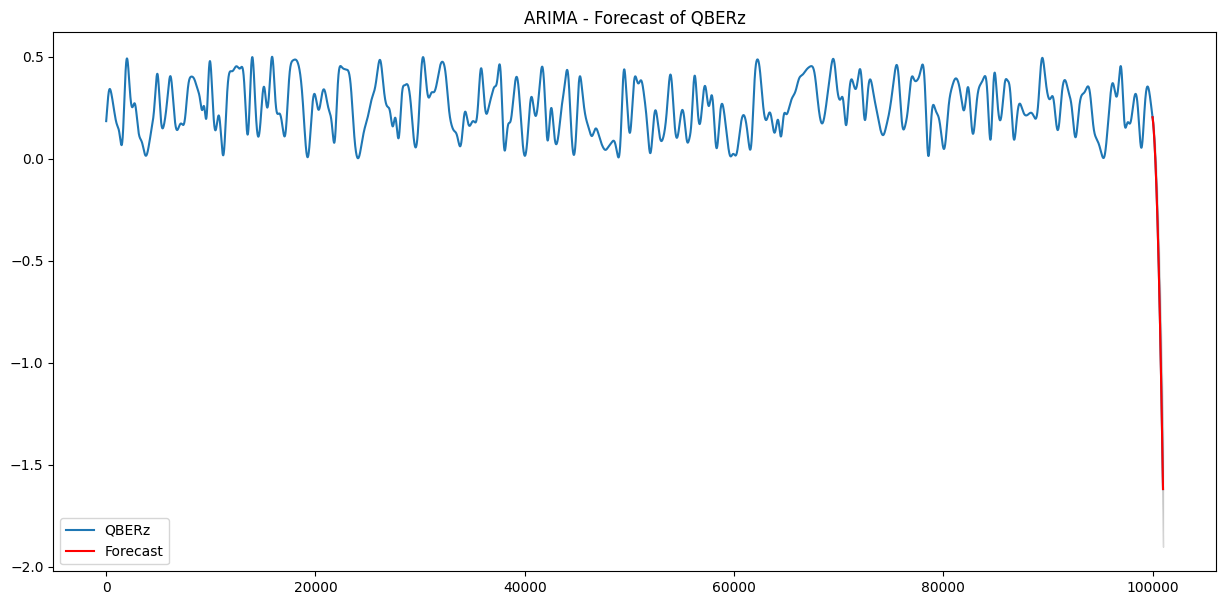

In [14]:
def forecast(ARIMA_model, periods=1000):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted)
    lower_series = pd.Series(confint[:, 0])
    upper_series = pd.Series(confint[:, 1])

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(qberz, label="QBERz")
    plt.plot(np.arange(len(qberz), len(qberz) + len(fitted_series)), fitted_series, color='#1f76b4', label='')
    plt.plot(np.arange(len(qberz), len(qberz) + len(fitted_series)), fitted, color='red', label="Forecast")
    plt.legend()
    plt.fill_between(np.arange(len(qberz), len(qberz) + len(fitted_series)), 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA - Forecast of QBERz")
    plt.show()

forecast(ARIMA_model)

As we can see from the plot below, this doesn’t seem to be a very accurate forecast. Maybe we need to change the model structure so that it takes into account seasonality?

SARIMA model so that we can account for seasonality.

In [15]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pmd.auto_arima(qberz, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


: 